# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import copy
import skimage.measure

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.datasets import load_digits

0


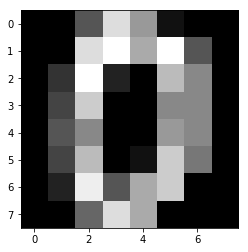

1


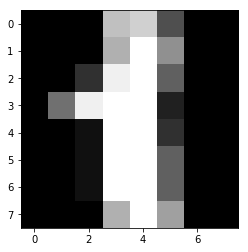

2


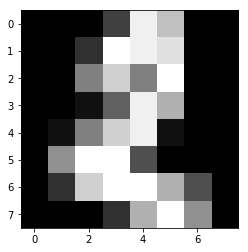

3


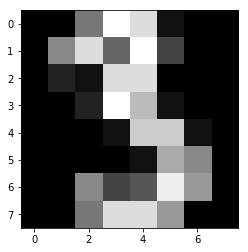

4


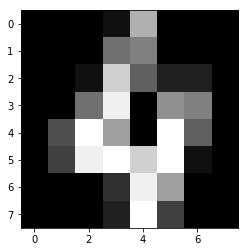

5


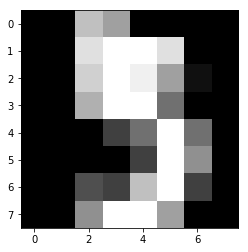

6


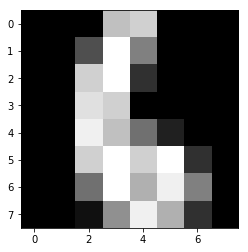

7


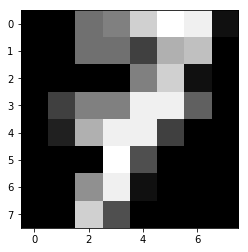

8


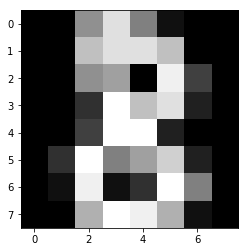

9


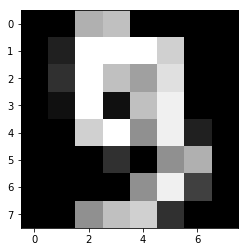

In [2]:
X,y = load_digits(n_class = 10, return_X_y = True)
X = X.reshape((-1,8,8))
for i in range(10):
    print(y[i])
    plt.imshow(X[i],"gray")
    plt.show()

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

print(X_train.shape)
print(X_test.shape)

(1347, 8, 8)
(450, 8, 8)


In [4]:
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [5]:
y_train.shape

(1347,)

## 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。


a
i
,
j
,
m
=
K
−
1
∑
k
=
0
  
F
h
−
1
∑
s
=
0
  
F
w
−
1
∑
t
=
0
 
x
(
i
+
s
)
,
(
j
+
t
)
,
k
w
s
,
t
,
k
,
m
+
b
m

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。


w
′
s
,
t
,
k
,
m
=
w
s
,
t
,
k
,
m
−
α
∂
L
∂
w
s
,
t
,
k
,
m
b
′
m
=
b
m
−
α
∂
L
∂
b
m

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。


∂
L
∂
w
s
,
t
,
k
,
m
=
N
o
u
t
,
h
−
1
∑
i
=
0
  
N
o
u
t
,
w
−
1
∑
j
=
0
 
∂
L
∂
a
i
,
j
,
m
x
(
i
+
s
)
(
j
+
t
)
,
k
∂
L
∂
b
m
=
N
o
u
t
,
h
−
1
∑
i
=
0
  
N
o
u
t
,
w
−
1
∑
j
=
0
 
∂
L
∂
a
i
,
j
,
m

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。


∂
L
∂
x
i
,
j
,
k
=
M
−
1
∑
m
=
0
  
F
h
−
1
∑
s
=
0
  
F
w
−
1
∑
t
=
0
 
∂
L
∂
a
(
i
−
s
)
,
(
j
−
t
)
,
m
w
s
,
t
,
k
,
m

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数


ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。



## 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。


N
h
,
o
u
t
=
N
h
,
i
n
+
2
P
h
−
F
h
S
h
+
1
N
w
,
o
u
t
=
N
w
,
i
n
+
2
P
w
−
F
w
S
w
+
1

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$ が高さ方向、 $w$ が幅方向である



In [6]:
def calc_out_shape(X, w, stride=1, pad=0):
    """
    X : 入力array(4次元を想定)
    w : フィルター
    stride=1
    pad=0
    
    return
    out_N : 出力のサイズ
    """
    _, _, input_height, input_width= X.shape
    
    _, _, filter_height, filter_width = w.shape
    
    out_height = 1 + (input_height + 2*pad - filter_height) // stride
    out_width = 1 + (input_width + 2*pad - filter_width) // stride
    
    return out_height, out_width

#     if self.pad == 'SAME':
#         out_height = ceil(float(in_height) / float(self.stride))
#         out_width  = ceil(float(in_width) / float(self.stride))

#     if self.pad == 'VALID':
#         out_height = ceil(float(in_height - filter_height + 1) / float(self.stride))
#         out_width  = ceil(float(in_width - filter_width + 1) / float(self.stride))


#     return int(Lo)

In [7]:
# shapeのテスト
xx = np.arange(108).reshape(3, 1, 6, 6)
ww = np.arange(108).reshape(4, 3, 3, 3)

calc_out_shape(xx, ww)

(4, 4)

In [8]:
class Conv2d:
    def __init__(self, activation, optimizer, filter_num, input_channel, filter_size, stride=1, pad=0):
        self.stride = stride
        self.pad = pad
        
        self.activation = activation
        self.optimizer = optimizer
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size
        if self.activation == 'sigmoid':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)            
        elif self.activation == 'tanh':
            initializer = XavierInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)          
        elif self.activation == 'relu':
            initializer = HeInitializer(self.filter_num, self.input_channel, self.filter_size)
            self.W = initializer.W(_, _)
            self.b = initializer.B(_)        
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def _calc_out_shape(self, H, FH, W, FW):
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        return out_h, out_w

    def _im2col(self, input_data, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
        ----------
        input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : フィルターの高さ
        filter_w : フィルターの幅
        stride : ストライド
        pad : パディング
        Returns
        -------
        col : 2次元配列
        """
        N, C, H, W = input_data.shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1

        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        
        return col

    def _col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
        ----------
        col :
        input_shape : 入力データの形状（例：(10, 1, 28, 28)）
        filter_h :
        filter_w
        stride
        pad
        Returns
        -------
        """
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape #フィルタ(FN : フィルタ数、C : チャネル数、FH : フィルタ高さ、FW : フィルタ幅)
        N, C, H, W = x.shape #入力データ(N : バッチ数、C : チャネル数、H : 高さ、W : 幅)
        
        # 2次元畳み込み後の出力サイズ(h : 高さ、w : 幅)
        out_h, out_w = self._calc_out_shape(H, FH, W, FW)

        # im2colによる4次元のデータの2次元への展開
        col = self._im2col(x, FH, FW, self.stride, self.pad)
        
        col_W = self.W.reshape(FN, -1).T # フィルタの転置
        out = np.dot(col, col_W) + self.b # 畳み込み演算
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) # 出力サイズの整形

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)    
        dx = self._col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx

In [9]:
class MaxPooling:
    '''
    2次元畳み込み層クラス
    Parameters
    --------------
     pool_h : int
         対象領域の高さ
     pool_w : int
         対象領域の幅
     filter_size : int
         フィルタの大きさ(縦横同じ)
     stride : int
         ストライド数
     pad : int
        パディング数    

    Attributes
    -------------
    X : 次の形のndarray, shape (N, C, H ,W)
        Xのコピー
    arg_max : 次の形のndarray, shape (N * out_h * out_w,)
        
    '''
    def __init__(self, pool_h=3, pool_w=3, stride=1, pad=0):
        #ハイパーパラメータ
        self.pool_h = pool_h #対象領域の高さ
        self.pool_w = pool_w #対象領域の幅
        self.stride = stride #ストライド数
        self.pad = pad #パディング数
        
        #インスタンス変数
        self.X = None #Xのコピー
        self.arg_max = None #

    def forward(self, X):
        """
        フォワード
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        -------
        out : 
            maxプーリングした結果

        """
        #サイズを取得
        N, C, H, W = X.shape
        
        #出力のサイズを取得
        out_h, out_w = self._out_shape(H, self.pool_h, W, self.pool_w)
        
        #im2col
        col = self._im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        #max_pooling
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        
        #配列を変換
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) #(N, out_h, out_w, C)→(N, C, out_h, out_w)

        #バックワードで使用
        self.X = X
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        """
        Parameters
        ----------
        dout : 
            outに関する損失Lの勾配
        
        Returns
        -------
        dX : 2次元配列
            Xに関する損失Lの勾配
        """        
        #位置を変える
        dout = dout.transpose(0, 2, 3, 1)
        
        #col2im
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dX = self._col2im(dcol, self.X.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dX

    def _im2col(self, input_data, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        input_data : 次の形のndarray, shape (N, C, H ,W)
            (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
        filter_h : int
            フィルターの高さ
        filter_w : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        -------
        col : 2次元配列
        """
        #サイズを取得
        N, C, H, W = input_data.shape
        
        #出力されるサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)

        #パディング
        img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
        
        #ゼロ配列を用意し、結果を格納
        col = np.zeros((N, C, FH, FW, out_h, out_w))
        for y in range(FH):
            y_max = y + stride * out_h
            for x in range(FW):
                x_max = x + stride * out_w
                col[:, :, y, x, :, :] = img[:, :, y: y_max: stride, x: x_max: stride]

        #位置変換、reshape
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1) 

        return col
    
    
    def _col2im(self, col, input_shape, FH, FW, stride=1, pad=0):
        """
        Parameters
        ----------
        col : 
            
        input_shape : 
            入力データの形状（例：(10, 1, 28, 28)）
        FH : int
            フィルターの高さ
        FW : int
            フィルターの幅
        stride : int
            ストライド
        pad : int
            パディング
        
        Returns
        ---------
        col2imの結果
        """
        #サイズ
        N, C, H, W = input_shape

        #出力のサイズ
        out_h, out_w = self._out_shape(H, FH, W, FW)
        
        #reshape、位置変換
        col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2) 

        #ゼロ配列を用意し、結果を格納
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(FH):
            y_max = y + stride*out_h
            for x in range(FW):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]
    
    
    def _out_shape(self, H, FH, W, FW):
        '''
        出力サイズを計算する関数

        Parameters
        --------------
        H : int
            高さ
        FH : int
            フィルターの高さ
        W : int
            幅
        FW : int
            フィルターの幅

        Returns
        ----------
        out_h : int
            出力するときの高さ
        out_w : int
            出力するときの幅
        '''
        out_h = 1 + int((H - FH) / self.stride)
        out_w = 1 + int((W- FW) / self.stride)
        
        return out_h, out_w

In [10]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)

    return col


In [11]:
# MaxPoolingテスト
pool = MaxPooling(pool_h=2, pool_w=2, stride=2)

a = np.random.randint(1, 100, 16).reshape(1, 1, 4, 4)
display(a)

print(pool.forward(a))
print(pool.arg_max)

array([[[[41, 39, 29, 12],
         [52, 18, 77, 58],
         [92, 91, 62, 86],
         [20, 49, 68,  1]]]])

[[[[52. 77.]
   [92. 86.]]]]
[2 2 0 1]


In [12]:
pooling = pool.forward(X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]))
print(pooling.shape)
print(pool.backward(pooling).shape)

(1797, 1, 4, 4)
(1797, 1, 8, 8)


## 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [13]:
# ゼロつく本コピー
class AveragePooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.X = None
        self.arg_max = None

    def forward(self, X):
        N, C, H, W = X.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        out = np.mean(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.X = x

        return out

    def backward(self, dA):
        ## indexの取得
        dA = dA.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dx = dA / pool_size

        return dx

## 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [14]:
class Flatten():
    '''
    平滑化を行うクラス
    
    Attribute
    -----------
    X : 次の形のndarray, shape (N, C, H ,W)
        入力
    '''
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        '''
        フォワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X_1d : 次の形のndarray, shape (N, C, H ,W)
        '''
        #1次元にする
        X_1d = X.reshape(X.shape[0], -1)
        
        #shapeを記録
        self.X_shape = X.shape
        
        return X_1d
    

    def backward(self, X):
        '''
        バックワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
        '''
        #shapeを戻す
        X = X.reshape(self.X_shape)
        
        return X

In [15]:
flat = Flatten()

flat.forward(X_train).shape

(1347, 64)

In [16]:
class Padding:
    """
    X : 配列
    n : パディング指定数
    """
    def __init__():
        pass
        
    def forward(self, X, n):
        N, C, H, W = X.shape
        if X.ndim == 1:   #1次元
            padding = np.pad(X, (n, n), 'constant')
        elif X.ndim == 2:    #2次元
            padding = np.pad(X, ((0, 0), (n, n)), 'constant')
        elif X.ndim == 3:    #3次元
            padding = np.pad(X, ((0, 0), (n, n), (n, n)), 'constant')
        else:   #4次元
            padding = np.pad(X, ((0, 0), (0, 0), (n, n), (n, n)), 'constant')
        
        return padding
    
    def backward(self, X, n):
        ## 作成中
        pass


In [17]:
def padding(X, n, op="SAME"):
    """
    X : 配列
    n : パディング指定数
    """
    if X.ndim == 1:   #1次元
        padding = np.pad(X, (n, n), 'constant')
    elif X.ndim == 2:    #2次元
        padding = np.pad(X, ((0, 0), (n, n)), 'constant')
    elif X.ndim == 3:    #3次元
        padding = np.pad(X, ((0, 0), (n, n), (n, n)), 'constant')
    else:   #4次元
        padding = np.pad(X, ((0, 0), (0, 0), (n, n), (n, n)), 'constant')
            
    return padding 

In [18]:
# 3次元の場合のテスト
padding(a, 2)

array([[[[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0, 41, 39, 29, 12,  0,  0],
         [ 0,  0, 52, 18, 77, 58,  0,  0],
         [ 0,  0, 92, 91, 62, 86,  0,  0],
         [ 0,  0, 20, 49, 68,  1,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]]])

In [19]:
# 4次元の場合のテスト
b = np.arange(384).reshape(3, 2, 8, 8)

padding(b, 2)

array([[[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   1,   2,   3,   4,   5,   6,   7,   0,   0],
         [  0,   0,   8,   9,  10,  11,  12,  13,  14,  15,   0,   0],
         [  0,   0,  16,  17,  18,  19,  20,  21,  22,  23,   0,   0],
         [  0,   0,  24,  25,  26,  27,  28,  29,  30,  31,   0,   0],
         [  0,   0,  32,  33,  34,  35,  36,  37,  38,  39,   0,   0],
         [  0,   0,  40,  41,  42,  43,  44,  45,  46,  47,   0,   0],
         [  0,   0,  48,  49,  50,  51,  52,  53,  54,  55,   0,   0],
         [  0,   0,  56,  57,  58,  59,  60,  61,  62,  63,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],

        [[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
    

## パディング
- [SAME,VALIDの違い](https://qiita.com/tadOne/items/48302a399dcad44c69c8)


ここまで動くことは確認

In [20]:
def _output_size(self, X, w):

    if self.pad == 'SAME':
        out_height = ceil(float(in_height) / float(self.stride))
        out_width  = ceil(float(in_width) / float(self.stride))

    if self.pad == 'VALID':
        out_height = ceil(float(in_height - filter_height + 1) / float(self.stride))
        out_width  = ceil(float(in_width - filter_width + 1) / float(self.stride))


    return int(Lo)

In [21]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        
        return np.dot(self.X, self.W) + self.B
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)

        # 更新
        self = self.optimizer.update(self)
        
        return dZ

# Initializer群
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma, debug=False):
        self.sigma = sigma
        self.debug = debug
        # self.shape
        
    def W(self, shape):
        """
        重みの初期化
        Parameters
        ----------
        input_N : int
          前の層のノード数
        shape : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.standard_normal(shape)
            
        return W



    def B(self, shape):
        """
        バイアスの初期化
        Parameters
        ----------
        shape : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.random.standard_normal(shape[1]).astype("float")
            
        return B

# Initializer群
class SimpleInitializer_Conv():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma, debug=False):
        self.sigma = sigma
        self.debug = debug
        # self.shape
        
    def W(self, shape):
        """
        重みの初期化
        Parameters
        ----------
        input_N : int
          前の層のノード数
        shape : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.standard_normal(shape)
            
        return W

    def B(self, shape):
        """
        バイアスの初期化
        Parameters
        ----------
        shape : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.random.standard_normal(shape[0]).astype("float")
            
        return B

class XavierInitializer:
    """
    Xavierのクラス
    """
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size 
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """     
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size)
        else: # 全結合層
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)       
        
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """       
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            B = np.random.randn(self.filter_num)
        else: # 全結合層
            B = np.zeros(n_nodes2)
        
        return B

class HeInitializer:
    """
    Heのクラス
    """
    def __init__(self, filter_num=None, input_channel=None, filter_size=None):        
        self.filter_num = filter_num
        self.input_channel = input_channel
        self.filter_size = filter_size       
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """      
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            W = np.random.randn(self.filter_num, self.input_channel, self.filter_size, self.filter_size) * np.sqrt(2 / self.filter_num) 
        else: # 全結合層
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """      
        if self.filter_num and self.input_channel and self.filter_size is not None: # 畳み込み層
            B = np.random.randn(self.filter_num)
        else: # 全結合層
            B = np.random.randn(n_nodes2)
        
        return B

# optimizer群
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB.mean(axis=0)
        
        return layer
        
class AdaGrad:
    """
    AdaGradのクラス
    Parameters
    ----------
    alpha : 学習率
    
    Attributes
    -------------
    lr : 学習率
    HW : int(初期値), ndarray
    HB :  int(初期値), ndarray
    """    
    def __init__(self, lr):
        self.lr = lr
        self.HW= 0 # 初期値：0
        self.HB = 0 # 初期値：0       

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #初期化
        self.HW = np.zeros_like(layer.W)
        self.HB = np.zeros_like(layer.B)
        
        #更新
        self.HW = self.HW + (layer.dW**2) #/ layer.dB.shape[0]
        self.HB = self.HB + (layer.dB**2).mean(axis=0)
        layer.W = layer.W - self.lr * 1 / np.sqrt(self.HW + 1e-7) * layer.dW #/ layer.dB.shape[0]
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.HB + 1e-7) * layer.dB.mean(axis=0)
        
        return layer
    
# Activation群
class Tanh():
    def __init__(self):
        pass
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        """
        dZ : n層目のバックプロバゲーション
        A :　n層目のフォワードプロバゲーションのA
        
        """
        y = dZ*((1-self.forward(self.A)**2))
        return y

class Sigmoid():
    def __init__(self):
        pass
        
    def forward(self, A):
        self.A = A
        return 1 / (1 + np.exp(-A))
    
    def backward(self, dZ):
        """
        dZ : n層目のバックプロバゲーション
        A :　n層目のフォワードプロバゲーションのA
         
        """
        y = dZ*(1-self.forward(self.A))*(self.forward(self.A))
        return y    

class Softmax():
    """
    ソフトマックス関数クラス
    """
    
    def __init__(self):
        pass
        
    def forward(self, A):
        # ソフトマックス計算 Zが出力値
        self.A = A
        c = np.max(A)
        self.Z = np.exp(A-c) / np.sum(np.exp(A-c), axis=1, keepdims=True)
        
        return self.Z
    
    def backward(self, y):
        """
        dZ　: 最終層のZ
        Y　:　（バッチ）サンプルラベル
        """
        dZ = self.Z - y
        
        # クロスエントロピー誤差計算
        batch_size = y.shape[0]
        error = -np.sum(y*np.log(self.Z + 1e-7)) / batch_size
        
        return dZ , error

# ゼロつくに乗っていたコード
class ReLU():
    """
    Relu関数クラス
    """
    
    def __init__(self):
        self.mask = None
        
    def forward(self, A):
        self.mask = (A <= 0)
        out = A.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dz):
        """
        Z:
        y:
        
        """
        dz[self.mask] = 0
        y = dz
        
        return y

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """

    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

In [22]:
class Scratch2dCNNClassifier:
    """
    ディープニューラルネットワーク分類器

    Parameters
    --------------
    activaiton : {'sigmoid', 'tanh', 'relu'} 
        活性化関数の種類
    n_nodes : list
        ノードの構成 例 [400, 200, 100]
    n_output : int
        出力層の数
    alpha : float
        学習率
    optimizer :  {'sgd', 'adagrad'}
        最適化手法の種類
    filter_num : int
        フィルタ数
    filter_size : int
        フィルタサイズ
    stride : int(初期値 : 1)
        ストライド
    pad : int(初期値 : 0)
        パディング
        
    Attributes
    -------------
    FC[n_layers] :  dict
        結合層を管理する辞書
    activation : dict
        活性化関数を管理する辞書
    self.epochs : int
        エポック数(初期値：10)
    self.batch_size : int
        バッチサイズ(初期値：20)
    self.n_features : int
        特徴量の数
    self.val_is_true : boolean
        検証用データの有無    
    self.loss : 空のndarray
        訓練データに対する損失の記録
    self.loss_val : 空のndarray
        検証データに対する損失の記録        
    """    
    def __init__(self, activation="relu", n_nodes=[400, 200, 100], n_output=10, lr=0.01, optimizer="sgd", filter_num=3, filter_size=3):
        self.select_activation = activation
        self.n_nodes = n_nodes
        self.n_output = n_output
        self.lr = lr
        self.select_optimizer = optimizer
        
        self.filter_num  = filter_num    # フィルタ数
        self.filter_size   = filter_size    # フィルタサイズ        
        self.stride          = 1               #ストライド
        self.pad             = 0               #パディング
            
    def _initialize_n_layers(self):
        """
        N層を初期化する。
        sigmoid関数とtanh関数が活性化関数の場合：Xavierを初期値
        ReLU関数が活性化関数の場合：Heを初期値
        """
        self.activation = dict()
        self.FC = dict()
        #プーリング層から全結合層につなぐFCクラスのインスタンス化
        if self.select_activation == 'sigmoid':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Sigmoid()
        elif self.select_activation == 'tanh':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = Tanh()
        elif self.select_activation == 'relu':
            self.FC[0] = FC(self.out_size, self.n_nodes[0], 
                            HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
            self.activation[0] = ReLU()

        #全結合層間のFCクラスのインスタンス化
        for n_layer in range(len(self.n_nodes)):            
            if n_layer == len(self.n_nodes) -1:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output, 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_output,
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
            else:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1], 
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Sigmoid()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              XavierInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = Tanh()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(self.n_nodes[n_layer], self.n_nodes[n_layer+1],
                                              HeInitializer(filter_num=None, input_channel=None, filter_size=None), self.optimizer)
                    self.activation[n_layer + 1] = ReLU()
                    
    def _calc_out_shape(self, H, FH, W, FW, layer):
        """
        ConvolutionレイヤとPoolingレイヤの出力サイズを計算する関数
        """        
        if layer == 'conv':
            out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
            out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        elif layer == 'pool':
            out_h = int(1 + (H - FH) / self.stride)
            out_w = int(1 + (W - FW) / self.stride)
        
        return out_h, out_w    
    
    def fit(self, X, y, X_val=None, y_val=None, batch_size=20, epochs=10):
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis]) 
        if X_val is not None and y_val is not None:
            y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
            
        self.epochs = epochs                            # エポック数     
        self.batch_size = batch_size               # バッチサイズ
        self.loss = np.zeros(self.epochs)        # 学習曲線・目的関数の出力用(訓練データ)
        self.loss_val = np.zeros(self.epochs) # 学習曲線・目的関数の出力用(検証データ)        
        
        #最適化クラスのインスタンス化
        if self.select_optimizer == 'sgd':
            self.optimizer = SGD(self.lr)
        elif self.select_optimizer == 'adagrad':
            self.optimizer = AdaGrad(self.lr)            
        
        #入力データのshape
        self.input_channel = X.shape[1]
        self.input_h = X.shape[2]
        self.input_w = X.shape[3]
        
        #畳み込み層クラスのインスタンス化
        self.conv = Conv2d(self.select_activation, self.optimizer, self.filter_num, self.input_channel, self.filter_size)
        
        #活性化関数クラスのインスタンス化
        if self.select_activation == 'sigmoid':
            self.activation_conv = Sigmoid()
        elif self.select_activation == 'tanh':
            self.activation_conv = Tanh()
        elif self.select_activation == 'relu':
            self.activation_conv = ReLU()
            
        #プーリング層クラスのインスタンス化
        self.pool = MaxPooling()   

        # 平滑化クラスのインスタンス化
        self.flatten = Flatten()

        #全結合前のサイズ
        out_h, out_w = self._calc_out_shape(self.input_h, self.filter_size, self.input_w, self.filter_size, 'conv')
        out_h, out_w = self._calc_out_shape(out_h, self.filter_size, out_w, self.filter_size, 'pool')
        self.out_size = out_h * out_w * self.filter_num
        
        #N層の初期化
        self._initialize_n_layers()
        
        #ミニバッチの取得
        get_mini_batch = GetMiniBatch(X, y_train_one_hot, self.batch_size)
        
        for epoch in range(self.epochs):
            print("epoch ", epoch + 1 , " processing . . .")
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train
                
                #フォワードプロバゲーション
                #畳み込み層
                self.A = self.conv.forward(self.X_)
                #活性化関数
                self.Z = self.activation_conv.forward(self.A)
                #プーリング層
                self.P = self.pool.forward(self.Z)
                #平滑化
                self.F = self.flatten.forward(self.P)
                
                self.A = self.FC[0].forward(self.F)
                self.Z = self.activation[0].forward(self.A)       
                for n_layer in range(1, len(self.n_nodes) + 1):
                    self.A = self.FC[n_layer].forward(self.Z)
                    self.Z = self.activation[n_layer].forward(self.A)
                
                #バックプロパゲーション
                self.dA, self.loss[epoch] = self.activation[len(self.n_nodes)].backward(self.y_) #最終層, 交差エントロピー誤差
                self.dZ = self.FC[len(self.n_nodes)].backward(self.dA) #最終層
                for n_layer in reversed(range(0, len(self.n_nodes))): #最終層 - 1
                    self.dA = self.activation[n_layer].backward(self.dZ)
                    self.dZ = self.FC[n_layer].backward(self.dA)

                #shapeの戻入
                self.dF = self.flatten.backward(self.dZ)
                
                #プーリング層
                self.dP = self.pool.backward(self.dF)
                #活性化関数
                self.dA = self.activation_conv.backward(self.dP)
                #畳み込み層
                self.dZ = self.conv.backward(self.dA)
                
    def predict(self,X):
        # フォワードプロバゲーション
        #畳み込み
        self.A = self.conv.forward(X)
        #活性化関数
        self.Z = self.activation_conv.forward(self.A)
        #プーリング層
        self.P = self.pool.forward(self.Z)
        #平滑化
        self.F = self.flatten.forward(self.P)

        self.A = self.FC[0].forward(self.F)
        self.Z = self.activation[0].forward(self.A)    
        for n_layer in range(1, len(self.n_nodes) + 1):
            self.A = self.FC[n_layer].forward(self.Z)
            self.Z = self.activation[n_layer].forward(self.A)
        
        return np.argmax(self.Z, axis=1)

In [23]:
scr_2d = Scratch2dCNNClassifier()
scr_2d.fit(X_train, y_train)

y_pred = scr_2d.predict(X_test)

epoch  1  processing . . .
epoch  2  processing . . .
epoch  3  processing . . .


/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:377: RuntimeWarning: invalid value encountered in true_divide
/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:404: RuntimeWarning: invalid value encountered in less_equal
/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch  4  processing . . .
epoch  5  processing . . .
epoch  6  processing . . .
epoch  7  processing . . .
epoch  8  processing . . .
epoch  9  processing . . .
epoch  10  processing . . .


In [24]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))

accuracy : 0.10222222222222223


filter_numとfiltersizeは引数
プーリング　平滑化　全結合層

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.10      1.00      0.19        46
          1       0.00      0.00      0.00        37
          2       0.00      0.00      0.00        49
          3       0.00      0.00      0.00        43
          4       0.00      0.00      0.00        48
          5       0.00      0.00      0.00        46
          6       0.00      0.00      0.00        44
          7       0.00      0.00      0.00        47
          8       0.00      0.00      0.00        43
          9       0.00      0.00      0.00        47

avg / total       0.01      0.10      0.02       450



/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。


Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.


https://diveintocode.gyazo.com/83358987a273743a589b9388dfdf59ac


※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数


## 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

## 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.


入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

2.


入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

3.


入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [26]:
# 問題9
def calc_out_shape_params(H, FH, W, FW, FN, P, S, C):
    out_h = int((H + 2 * P - FH) / S) + 1
    out_w = int((W + 2 * P - FW) / S) + 1
    parameter = FH * FW * C * FN + FN
        
    return out_h, out_w, parameter

In [27]:
# 1.入力サイズ : 144×144, 3チャンネル フィルタサイズ : 3×3, 6チャンネル ストライド : 1 パディング : なし
H,W,C = (144,144,3)
FH,FW, FN = (3,3,6)
S, P = 1, 0

OH, OW, parameter = calc_out_shape_params(H, FH, W, FW, FN, P, S, C)

print('出力サイズ(OH × OW × FN) : {} × {} × {}'.format(OH, OW, FN))
print('パラメータ : {}'.format(parameter))

出力サイズ(OH × OW × FN) : 142 × 142 × 6
パラメータ : 168


In [28]:
# 2.入力サイズ : 60×60, 24チャンネル フィルタサイズ : 3×3, 48チャンネル ストライド　: 1 パディング : なし
H,W,C = (60,60,24)
FH,FW, FN = (3,3,48)
S, P = 1, 0

OH, OW, parameter = calc_out_shape_params(H, FH, W, FW, FN, P, S, C)

print('出力サイズ(OH × OW × FN) : {} × {} × {}'.format(OH, OW, FN))
print('パラメータ : {}'.format(parameter))

出力サイズ(OH × OW × FN) : 58 × 58 × 48
パラメータ : 10416


In [29]:
# 3.入力サイズ : 20×20, 10チャンネル フィルタサイズ: 3×3, 20チャンネル ストライド : 2 パディング : なし
H,W,C = (20,20,10)
FH,FW, FN = (3,3,20)
S, P = 2, 0

OH, OW, parameter = calc_out_shape_params(H, FH, W, FW, FN, P, S, C)

print('出力サイズ(OH × OW × FN) : {} × {} × {}'.format(OH, OW, FN))
print('パラメータ : {}'.format(parameter))

出力サイズ(OH × OW × FN) : 9 × 9 × 20
パラメータ : 1820


## 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
高さや幅方向を持たない1×1のフィルタの効果

## アドバンス課題については平均プーリングのみの回答となります。